In [3]:
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import seaborn as sns 
import nltk as nlp
import string
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [4]:
plt.rc("font",size = 15)
sns.set(style="dark")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
%matplotlib inline
pd.set_option('display.max_columns',500)

# Read in data and overview 

In [5]:
# import
train= pd.read_csv('train.csv', encoding = 'latin-1')
test = pd.read_csv('test.csv',encoding = 'latin-1')
prod = pd.read_csv('product_descriptions.csv')

## Quick analysis

In [6]:
# quick analysis 
def quick(df): 
    print('Data Types: \n',df.dtypes)
    print('\nData Shape: \n',df.shape)
    print('\nOverall Info: \n', df.info())
    print('\nNull Values: \n', df.isna().sum())

### Set Analysis

We observe the following: 

1) Train: No missing values, four columns, target variable is the relevance between search terms and the title of the product. Target variable is continious

2) Test: Again No missing values, similar to before 

3) Product description: Contains detailed description of the product, and an id to match, not every product has a related id

In [7]:
#analysis
print(quick(train),quick(test),quick(prod))

Data Types: 
 id                 int64
product_uid        int64
product_title     object
search_term       object
relevance        float64
dtype: object

Data Shape: 
 (74067, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74067 non-null  int64  
 1   product_uid    74067 non-null  int64  
 2   product_title  74067 non-null  object 
 3   search_term    74067 non-null  object 
 4   relevance      74067 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB

Overall Info: 
 None

Null Values: 
 id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64
Data Types: 
 id                int64
product_uid       int64
product_title    object
search_term      object
dtype: object

Data Shape: 
 (166693, 4)
<class 'pandas.core.frame.DataFrame'>
RangeInd

### EDA

We observe the following through our initial analysis: 

1) We have two key features that stand out; title, description, search term of the product 

2) 3.0 (high) and 2.3 (med) relevance ratings are the most common ones given; the search term and product relevancy is currently quite efficient. 

3) We also added the length of the search term expecting that their length should impact its relevancy to the product title

In [8]:
# jOIN THE SETS 
#train and test sets 
data= pd.concat([train,test])
data = pd.merge(prod,data, on = 'product_uid')

In [9]:
# add length of the search query 
data['len_query'] = data['search_term'].str.split().str.len()

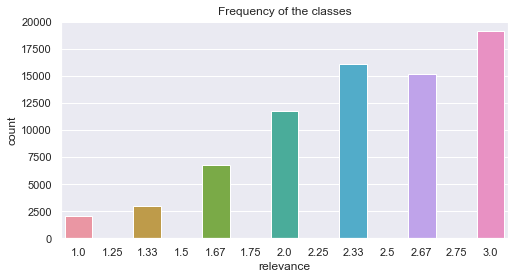

In [10]:
#visualize the frequency of the relavence 
data.relevance.value_counts()
plt.figure(figsize = (8,4))
sns.countplot(data = data, x = 'relevance')
plt.title('Frequency of the classes')
plt.show()

# Data Cleaning 

## Noise Removal 

We removed the following noise from our data: 

1) Html text and html tags 

2) Stopwords 

3) Special characters  

In [11]:
#imports 
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [12]:
#making stopword corpus 
stop = set(stopwords.words('english'))
punct = list(string.punctuation)
stop.update(punct)

In [13]:
#cleaning
def strip_html(text): 
    soup = BeautifulSoup(text,'html.parser')
    return soup.get_text()
def stop_clean(text): 
    final = []
    for word in word_tokenize(text): 
        if word not in stop:
            final.append(word)
    return " ".join(final)
def strip_url(text): 
    return re.sub(r'http\S+',"",text) 
def strip_brack(text): 
    text = re.sub(r'\[[^]]*\]', "", text)
    return re.sub(r'\([^)]*\)',"",text)

def clean(text): 
    text = strip_html(text)
    text = stop_clean(text)
    text = strip_url(text)
    text = strip_brack(text)
    return text

In [14]:
#transfroming
data['product_title']= data['product_title'].apply(lambda x: clean(x))
data['search_term'] = data['search_term'].apply(lambda x: clean(x))
data['product_description'] = data['product_description'].apply(lambda x: clean(x))

## Lemmatization 

In [15]:
#imports 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer

In [16]:
lem = WordNetLemmatizer()
stem = SnowballStemmer(language='english')

In [17]:
def lemmatize(text): 
    final= []
    for word in word_tokenize(text): 
        final.append(lem.lemmatize(word,'v'))
    return " ".join(final)

In [18]:
#lemmatize 
data['product_title']= data['product_title'].apply(lambda x: lemmatize(x))
data['search_term'] = data['search_term'].apply(lambda x: lemmatize(x))
data['product_description'] = data['product_description'].apply(lambda x: lemmatize(x))

# Feature Eng and modeling

## td-idf

In [20]:
# import 
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
td = TfidfVectorizer(min_df= 0.1, max_df= 1.0, token_pattern= r'\w{2,}',strip_accents='ascii')
td2 = TfidfVectorizer(min_df= 0.4, max_df= 1.0, token_pattern= r'[a-zA-Z]{2,}',strip_accents='ascii')
td3 = TfidfVectorizer(min_df= 0, max_df= 1.0, token_pattern= r'\w{2,}',strip_accents='ascii')
prod_title = td.fit_transform(data['product_title'].values)
prod_title = prod_title.toarray()
prod_desc = td2.fit_transform(data['product_description'].values)
prod_desc = prod_desc.toarray()
search = td3.fit_transform(data['search_term'].values)
search = search.toarray()


In [ ]:
prod_title.

In [21]:
transf = np.append(prod_title,prod_desc,axis = 1)
transf = np.append(transf, search,axis =1)
vocab = td.get_feature_names() + td2.get_feature_names() + td3.get_feature_names()

In [22]:
feat = pd.DataFrame(transf, columns = vocab)

In [23]:
feat.head()

,ft,white,the,00,000,0000,000btu,001,00225,003234,00x30,01,010k,013844ifi,014,019,01cc003656,02,020,0210169,025,026,02ivol2339,031,032888076358,035,037,043156889930,045,045410,047,051,065,068,069,07,070,0754,08,080,081,084,0ah,0cu,0mm,0roofing,0z,10,100,1000,10000,100087613,1000ft,1000w,1003,10030bulk,100672960,100a,100feet,100ft,100ib,100w,100watts,101,102,1021424,1030,10302,10306,104,1048,104dbl,105,105519,105712,106,10634,107,1075,108,10851,108x108,1097686,10ft,10guage,10in,10mm,10pc,10s,10w,10w30,10watts,10x,10x1,10x10,10x100,10x10x10,10x12,10x13,10x14,10x16,10x20,10x30x1,10x32x4,10x50,10x51,10x8,10z,11,110,1101365ma,1109,110a,110v,110w,111,11240,115,1151ra,115r,116,117,118,11ft,11mm,12,120,1200,12000,1202,1205,120g,120gal,120v,120vac,120w,1225,124,125,125lb,125v,1275,129,12by16,12d,12ft,12in,12mm,12oz,12pack,12v,12v5w,12vac,12volt,12w,12x,12x12,12x16,12x17,12x1x40,12x20,12x24,12x24x1,12x3,12x30,12x30x1,12x36,12x4,12x6,13,130,1301ele,130224054,130489,133149,136,1366077,136883,13990,13w,13x1,13x13,13x2,13yx78ks011,14,1400,14000,140295003,1407,140v,14254454,144,148,14ft,14heightx24withx15depth,14in,14x14,14x18x1,14x24x1,14x30,14x4,15,150,1500,150ft,150w,1540,157331208,1599,15a,15d,15ft,15h,15in,15lb,15w,15x23,15x30,16,160,1600,16031kit,160mm,1610,1640vs,164416,1648,1649,165,1660,16650,169,16d,16ft,16ga,16hex,16in,16inch,16t9,16x14,16x16x60boxes,16x20,16x201x1,16x20x4,16x24,16x25,16x25x1,16x25x5,16x26,16x30,...,wider,widespread,widow,width,wiemans,wife,wifi,wiga,wihite,wild,wildflower,wilkins,williams,williamsburg,willow,wilmarut,wilsonart,winch,winchester,wind,windemere,windham,windo,windos,window,windowair,windowbalance,windows,windowtioners,windoww,windser,windsor,windtunnel,windward,wine,winegard,wing,wingnut,winix,wink,winow,winsome,winsor,winston,winter,winterizer,wipe,wire,wired,wireless,wirell,wiremesh,wiremold,wirenuts,wirerless,wiring,wirless,wirlpool,wise,wit,witch,with,withe,without,wjth,wm624,wndow,wndows,wod,wolf,wolman,woltage,womens,wonderboard,wondow,woo,wood,woodbury,woodceramic,woodcrafters,woodebn,wooden,woodenworks,woodflooring,woodford,woodgrain,woodland,woodmark,woodpeckers,woodrx,woods,woodsaddle,woodstoves,woodwen,woody,wool,wooster,woper,work,workbench,workforce,workhorse,worklight,worklite,workpro,workshop,workstar,workstation,worksurface,workx,world,worldpool,worm,worx,wr,wrachet,wrap,wraparound,wre,wreath,wreaths,wreck,wren,wrench,wringer,wrp,wrt111sfdb,wrt341tfw,ws,ws1,wsf26c2exf,wsher,wtf,ww,wwe,wwod,wye,wyndham,x1,x10,x100,x10ft,x12,x12in,x12x12,x12x97,x15,x16,x18,x19,x2,x20x,x22,x24,x24h,x25,x26,x29,x2in,x2x4,x3,x30,x32,x330,x34,x4,x42,x45,x5,x6,x60,x6ft,x7,x78h,x7ft,x7in,x8,x80,x81,x95,x96,xbox,xcelite,xenon,xhhw,xhose,xl,xmas,xp,xps,xr,xrf,xs,xt1,xt30,xtra,xtreme,xy_2900600_u,xylem,yale,yankees,yard,yardgard,yardguard,yardman,yardwaste,yds,yeaer,year,yel,yelloe,yellow,yonkers,york,yosemite,young,ypermethrin,yr,z425,zacatecas,zall,zamma,zapper,zaw,zella,zen,zenith,zenity,zep,zero,zeroturn,zhi,zinc,zing,zinsco,zinser,zinsser,zip,zipper,zise,zo,zodiac,zone,zoom,zoroufy,zucchini,zuri,zurn,zwave,zymes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## modeling 

In [24]:
# import 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR 
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split

In [2]:
# prep the data 
feat[['len_query','relevance']] = data[['len_query','relevance']]


NameError: name 'data' is not defined

In [ ]:
x = feat.drop('relavance',axis = 1)
y = feat['relavance']

In [ ]:
rf = RandomForestRegressor()